In [ ]:
# Uncomment if use Colab
'''from google.colab import drive
drive.mount('/content/gdrive', force_remount=True) #mount google drive
'''

In [1]:
# Nothing better to begin with than by importing some necessary dependencies. 
%matplotlib inline
import torch
import matplotlib.pyplot as plt
import math
import numpy as np
import torch.nn as nn
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random

#  Coursework


* The **goal** of the CW is similar to that of Week 2's Lab: fitting a curve to data, also known as **curve fitting**. 
* This has applications in many different disciplines that make use of AI: FinTech, Physics Modelling, or even Sports. 
* For example, we might be interested in learning the evolution (over time) of the price of a specific product in different countries. This can depend on several factors: the product itself, the country, the initial value of the product's price, etc. 
* As usual, we are interested in learning a model that finds these relationships *from the data*. 


### Learning a family of functions

* The main difference with Week 2's Lab is that we will learn a network that does not learn a single function but a *family of functions*.
* We will consider a family of sinusoidal functions. 
* Below you can find the code generating the data according to different random sinusoidal functions $\{f_a\}$. We randomly generate a set of 40 points in the x-axis in the interval $[-2, 2]$, slightly randomly shifted. Our functions will have the form of $y = f_a(x) = a * sin(x+a)$ where each $a$ will be randomly sampled for each function from interval $[-2, 2]$.  To "draw" a function $f_a$, we first choose some $a \sim U(-2,2)$ and then we compute $f_a$ using the above formula for all the $x$ in the x-axis. 


In [2]:
Nf = 2000 # the number of different functions f that we will generate
Npts = 40 # the number of x values that we will use to generate each fa
x = torch.zeros(Nf, Npts, 1)
for k in range(Nf):
    x[k,:,0] = torch.linspace(-2, 2, Npts)

x += torch.rand_like(x)*0.1
a = -2 + 4*torch.rand(Nf).view(-1,1).repeat(1, Npts).unsqueeze(2)

## The Learning Goal

* Because we are dealing with a family of functions and not just a single function, our model must be able to perform two tasks: *Function Selection* and *Regression*.
* Function selection means that given some *additional* input (to be defined below) the model somehow must choose which function $f_a$ from the family of functions $\{f_a\}$ it needs to model.
* Once the correct function is picked then the model must perform regression i.e. learn the relationship $y=f_a(x)$.




## The Learning Objective

* During training we randomly sample functions from the family of functions $\{f_a\}$. For each $f_a$, we are provided with the (input, output) pairs $(x_t, y_t), t=1,\dots,N_{pts}$.

* To perform *Function Selection*, a **random subset** of $(x_t, y_t), t=1,\dots,N_{pts}$ is provided as auxiliary input to the model during *both training and testing*. These auxiliary data is called the *context data:* $(x_c, y_c), c=1,\dots,N_c$. 

* Note that the total number of context points $N_c$ should be different (and randomly chosen) for every batch so that the model learns to handle different number of context points at test time. This means that the model should be able to work for e.g. $N_c=5$ but also for $N_c=12$ etc.

* Our model will take the context pairs $(x_c, y_c)$ and input values $x_t$ and will produce the estimated values $\hat{y}_t$. 

* During training we have access to the ground-truth values $y_t$, and thus we can compute a loss between the model's predictions $\hat{y}_t$ and the ground-truth values $y_t$.  


## The Model

* Our model will consists of 2 MLPs which must be jointly trained.
* The first MLP is called the *Context Encoder* or Encoder. The Encoder will take as input each pair $(x_c, y_c)$ and will produce a corresponding feature representation $r_c$ of dimension $r_{dim}$.
* A total context feature is produced by averaging over all features: $r_C= \frac{1}{N}\sum_c r_c$.
* The second MLP is called the Decoder. It takes as input the $r_C$ and each input data $x_t$ and produces the model's prediction $\hat{y}_t$. 



![Encoder-Decoder](CW1.png)



## Architectures

* The Encoder and the Decoder are **MLPs**. You can experiment with your own architectures. You can also choose to implement the following architectures:
    * *Encoder*: It will map the input pair $(x_c, y_c)$ to some features of dimension $h_{dim}$ using 2 *hidden* layers. A final layer will produce the feature representation $r_c$ of dimension $r_{dim}$.
    * *Decoder*: It will map the input pair $(r_C, x_t)$ to some features of dimension $h_{dim}$ using 2 *hidden* layers. A final layer will produce the model's prediction $\hat{y}_t$.

## Tasks

* You have to implement the following:
    1. Create the training dataset and dataloader (10%). 
    2. Create the Encoder and Decoder (20 + 20%). 
    3. Create the optimizer and the loss for your model (10%).
    4. Write the training script that will train the model and print the training loss (30%).
    5. Evaluate the model on some validation data. Plot some predictions. (10%). 

* You might want to explore the impact of the following design choices and hyperparameters:
    1. Number of hidden layers and $h_{dim}$, and  $r_{dim}$.
    1. Type of optimizer, batch-size and all relevant hyper-parameters from Week 5.

# Importing libraries

In [3]:
%matplotlib inline
import torch
import matplotlib.pyplot as plt
import math
import numpy as np
import torch.nn as nn
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random

# Dataset Creation

In [4]:
Nf = 2000 # the number of different functions f that we will generate
Npts = 40 # the number of x values that we will use to generate each fa
x = torch.zeros(Nf, Npts, 1)
for k in range(Nf):
    x[k,:,0] = torch.linspace(-2, 2, Npts)

x += torch.rand_like(x)*0.1
a = -2 + 4*torch.rand(Nf).view(-1,1).repeat(1, Npts).unsqueeze(2)

#generating the dependent variable Y using function
y=a*torch.sin(x+a)

In [5]:
#getting length
print(len(x))
print(len(y))

2000
2000


# Plotting these points

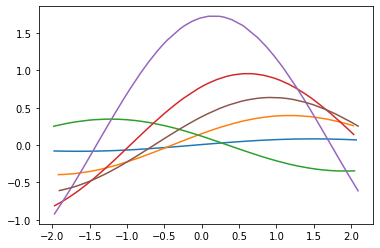

In [6]:
#plotting some points
plt.plot(x[0,:],y[ 0,: ])
plt.plot(x[1,:],y[1,:])
plt.plot(x[2,:],y[2,:])
plt.plot(x[3,:],y[3,:])
plt.plot(x[4,:],y[4,:])
plt.plot(x[5,:],y[5,:])

# Reshape data

In [7]:
#reshaping and assigning to x_train,y_train
x_train=np.array(x,dtype=np.float32)
x_train=x_train.reshape(-1,1)

y_train=np.array(y,dtype=np.float32)
y_train=y_train.reshape(-1,1)

# Encoder class

In [8]:
# Encoder Class
class Encoder(nn.Module):
    def __init__(self, seq_len, no_features, embedding_size):
        super().__init__()
        
        self.seq_len = seq_len
        self.no_features = no_features    # The number of expected features(= dimension size) in the input x
        self.embedding_size = embedding_size   # the number of features in the embedded points of the inputs' number of features
        self.hidden_size = (2 * embedding_size)  # The number of features in the hidden state h
        self.LSTM1 = nn.LSTM(
            input_size = no_features,
            hidden_size = embedding_size,
            num_layers = 1,
            batch_first=True
        )
        
    def forward(self, x):
        # Inputs: input, (h_0, c_0). -> If (h_0, c_0) is not provided, both h_0 and c_0 default to zero.
        x, (hidden_state, cell_state) = self.LSTM1(x)  
        last_lstm_layer_hidden_state = hidden_state[-1,:,:]
        return last_lstm_layer_hidden_state

# Decoder class

In [9]:
class Decoder(nn.Module):
    def __init__(self, seq_len, no_features, output_size):
        super().__init__()

        self.seq_len = seq_len
        self.no_features = no_features
        self.hidden_size = (2 * no_features)
        self.output_size = output_size
        self.LSTM1 = nn.LSTM(
            input_size = no_features,
            hidden_size = self.hidden_size,
            num_layers = 1,
            batch_first = True
        )

        self.fc = nn.Linear(self.hidden_size, output_size)
        
    def forward(self, x):
        x = x.unsqueeze(1).repeat(1,2000 ,1)
        x, (hidden_state, cell_state) = self.LSTM1(x)
        x = x.reshape((-1,2000, self.hidden_size))
        out = self.fc(x)
        return out

# LTSM class

In [10]:
# joining both encoder and decoder class using LSTM 
class LSTM_AE(nn.Module):
    def __init__(self, seq_len, no_features, embedding_dim, learning_rate, every_epoch_print, epochs, patience, max_grad_norm):
        super().__init__()
        
        self.seq_len = seq_len
        self.no_features = no_features
        self.embedding_dim = embedding_dim

        self.encoder = Encoder(self.seq_len, self.no_features, self.embedding_dim)
        self.decoder = Decoder(self.seq_len, self.embedding_dim, self.no_features)
        
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.patience = patience
        self.max_grad_norm = max_grad_norm
        self.every_epoch_print = every_epoch_print
    
    def forward(self, x):
        torch.manual_seed(0)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded
    
   

# Regression 

In [11]:
import torch
from torch.autograd import Variable
class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)

    def forward(self, x):
        out = self.linear(x)
        return out

In [12]:
inputDim = 1        # takes variable 'x' 
outputDim =1      # takes variable 'y'
learningRate = 0.01 
epochs = 100

model = linearRegression(inputDim, outputDim)
##### For GPU #######
if torch.cuda.is_available():
    model.cuda()


In [13]:
#loss= Mean Squared Error
#optimization= stochastic gradient descent
criterion = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

In [14]:
for epoch in range(epochs):
    # Converting inputs and labels to Variable
    if torch.cuda.is_available():
        inputs = Variable(torch.from_numpy(x_train).cuda())
        labels = Variable(torch.from_numpy(y_train).cuda())
    else:
        inputs = Variable(torch.from_numpy(x_train))
        labels = Variable(torch.from_numpy(y_train))

    # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()

    # get output from the model, given the inputs
    outputs = model(inputs)

    # get loss for the predicted output
    loss = criterion(outputs, labels)
    print(loss)
    # get gradients w.r.t to parameters
    loss.backward()

    # update parameters
    optimizer.step()

    print('epoch {}, loss {}'.format(epoch, loss.item()))

tensor(1.0560, grad_fn=<MseLossBackward>)
epoch 0, loss 1.0559861660003662
tensor(1.0248, grad_fn=<MseLossBackward>)
epoch 1, loss 1.024811863899231
tensor(0.9952, grad_fn=<MseLossBackward>)
epoch 2, loss 0.99520343542099
tensor(0.9671, grad_fn=<MseLossBackward>)
epoch 3, loss 0.9670801758766174
tensor(0.9404, grad_fn=<MseLossBackward>)
epoch 4, loss 0.9403657913208008
tensor(0.9150, grad_fn=<MseLossBackward>)
epoch 5, loss 0.9149882793426514
tensor(0.8909, grad_fn=<MseLossBackward>)
epoch 6, loss 0.8908789157867432
tensor(0.8680, grad_fn=<MseLossBackward>)
epoch 7, loss 0.8679728507995605
tensor(0.8462, grad_fn=<MseLossBackward>)
epoch 8, loss 0.846208393573761
tensor(0.8255, grad_fn=<MseLossBackward>)
epoch 9, loss 0.8255276083946228
tensor(0.8059, grad_fn=<MseLossBackward>)
epoch 10, loss 0.8058748245239258
tensor(0.7872, grad_fn=<MseLossBackward>)
epoch 11, loss 0.7871980667114258
tensor(0.7694, grad_fn=<MseLossBackward>)
epoch 12, loss 0.769447386264801
tensor(0.7526, grad_fn=<Mse

# Graph

[[0.55273885]
 [0.5437942 ]
 [0.5366035 ]
 ...
 [0.33025062]
 [0.3213512 ]
 [0.31686243]]


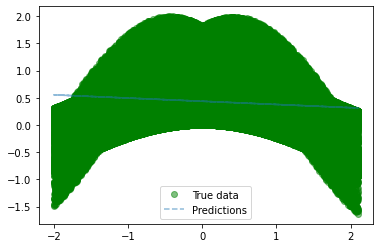

In [15]:
with torch.no_grad(): # we don't need gradients in the testing phase
    if torch.cuda.is_available():
        predicted = model(Variable(torch.from_numpy(x_train).cuda())).cpu().data.numpy()
    else:
        predicted = model(Variable(torch.from_numpy(x_train))).data.numpy()
    print(predicted)

plt.clf()
plt.plot(x_train, y_train, 'go', label='True data', alpha=0.5)
plt.plot(x_train, predicted, '--', label='Predictions', alpha=0.5)
plt.legend(loc='best')
plt.show()